In [2]:
import numpy as np
import pandas as pd

In [3]:
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import pickle
%matplotlib inline

In [18]:
train = pd.read_csv('dbpedia_csv/train.csv', header=None)
test = pd.read_csv('dbpedia_csv/test.csv', header = None)

In [19]:
train.drop(columns=[1], axis = 1, inplace=True)
test.drop(columns=[1], axis = 1, inplace=True)

In [22]:
train = pd.DataFrame(np.random.permutation(train.values))
train = train.iloc[:50000]

In [24]:
test = pd.DataFrame(np.random.permutation(test.values))
test = test.iloc[:10000]

In [23]:
train

,0,1
0,12,June 2010 Rehearsal is an extended play by th...
1,2,Saint David's School is an independent Roman ...
2,7,Villa Jeanneret and Villa La Roche are two ho...
3,11,Astridia is a genus of plant in family Aizoac...
4,4,Ádám Hamar (born in 20 March 1987 in Cegléd) ...
...,...,...
49995,5,Robert Milledge Charlton (January 19 1807 – J...
49996,5,Alan A. Altshuler is an American academic and...
49997,7,County Square is a shopping centre in Ashford...
49998,5,William Wesley Bill Hiltz (2 November 1873 - ...


In [25]:
test

,0,1
0,4,Kārlis Skrastiņš (July 9 1974 – September 7 2...
1,11,Colutea arborescens is a species of leguminou...
2,11,Kunzea ambigua commonly known as the White Ku...
3,6,The Partenavia P.59 Jolly was an Italian two-...
4,4,Mulualem Girma Teshale (born December 9 1987 ...
...,...,...
9995,5,David Clendenin (unknown – unknown) was an in...
9996,12,Other World: Remixes and Rarities released in...
9997,9,Mnichów [ˈmnixuf] is a village in the adminis...
9998,4,Björn Goldschmidt (born 3 December 1979 in Ka...


# See Distribution of Categories

<AxesSubplot:xlabel='0'>

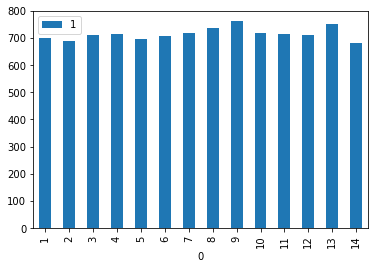

In [26]:
test.groupby(0).count().plot.bar()

<AxesSubplot:xlabel='0'>

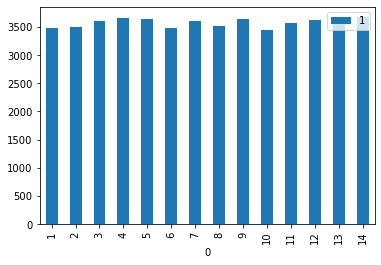

In [27]:
train.groupby(0).count().plot.bar(ylim=0)

**The categories seem to be evenly distributed**

In [29]:
stemmer = PorterStemmer()
words = stopwords.words("english")
train['cleaned'] = train[1].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
test['cleaned'] = test[1].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [30]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features_train = vectorizer.fit_transform(train['cleaned']).toarray()
final_features_test = vectorizer.fit_transform(test['cleaned']).toarray()

(10000, 16398)

In [31]:
final_features_train.shape

(50000, 78570)

In [32]:
final_features_test.shape

(10000, 16398)

In [39]:
X_train = train['cleaned']
X_test = test['cleaned']
y_train = train[0]
y_test = test[0]

In [35]:
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', RandomForestClassifier())])

In [40]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [41]:
model = pipeline.fit(X_train, y_train)
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

In [42]:
ytest = np.array(y_test)

In [43]:
print(classification_report(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           1       0.89      0.85      0.87       699
           2       0.93      0.97      0.95       688
           3       0.89      0.82      0.86       709
           4       0.98      0.97      0.97       715
           5       0.95      0.94      0.94       694
           6       0.94      0.96      0.95       706
           7       0.93      0.89      0.91       719
           8       0.95      0.96      0.96       735
           9       0.99      0.99      0.99       762
          10       0.94      0.94      0.94       717
          11       0.96      0.94      0.95       713
          12       0.96      0.98      0.97       712
          13       0.96      0.98      0.97       749
          14       0.87      0.93      0.90       682

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



# Deep Learning Approach 

In [47]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional


In [48]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankitasingh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [49]:
vocab_size = 5000 # make the top list of words (common words)
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary
training_portion = .8

In [50]:
articles = []
labels = []

with open("dbpedia_csv/train.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)

In [51]:
with open("dbpedia_csv/test.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace(' ', ' ')
        articles.append(article)

In [52]:
len(articles)

629998

In [54]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

In [56]:
print('train_size', train_size)
print(f'train_articles {len(train_articles)}')
print('train_labels', len(train_labels))
print('validation_articles', len(validation_articles))
print('validation_labels', len(validation_labels))


train_size 503998
train_articles 503998
train_labels 503998
validation_articles 126000
validation_labels 126000


In [57]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [58]:
train_sequences = tokenizer.texts_to_sequences(train_articles)

In [59]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [60]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [61]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))


In [68]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(15, activation = 'softmax'))

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 15)                1935      
                                                                 
Total params: 387,983
Trainable params: 387,983
Non-trainable params: 0
_________________________________________________________________


In [70]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)

In [72]:
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)


Epoch 1/10
15750/15750 - 2505s - loss: 1.0658 - accuracy: 0.6145 - val_loss: 7.0977 - val_accuracy: 0.3905 - 2505s/epoch - 159ms/step
Epoch 2/10
15750/15750 - 13857s - loss: 0.9720 - accuracy: 0.6419 - val_loss: 8.4192 - val_accuracy: 0.3945 - 13857s/epoch - 880ms/step
Epoch 3/10
15750/15750 - 4142s - loss: 0.9550 - accuracy: 0.6476 - val_loss: 8.8048 - val_accuracy: 0.4040 - 4142s/epoch - 263ms/step
Epoch 4/10
15750/15750 - 4058s - loss: 0.9459 - accuracy: 0.6507 - val_loss: 8.3792 - val_accuracy: 0.4038 - 4058s/epoch - 258ms/step
Epoch 5/10
15750/15750 - 4053s - loss: 0.9398 - accuracy: 0.6531 - val_loss: 8.7812 - val_accuracy: 0.4069 - 4053s/epoch - 257ms/step
Epoch 6/10
15750/15750 - 4129s - loss: 0.9353 - accuracy: 0.6546 - val_loss: 8.6640 - val_accuracy: 0.4028 - 4129s/epoch - 262ms/step
Epoch 7/10
15750/15750 - 4008s - loss: 0.9313 - accuracy: 0.6558 - val_loss: 8.7604 - val_accuracy: 0.4014 - 4008s/epoch - 254ms/step
Epoch 8/10
15750/15750 - 2822s - loss: 0.9284 - accuracy: 0.

# Deep learning using Roberta

In [3]:
train = pd.read_csv('dbpedia_csv/train.csv', header = None)
test = pd.read_csv('dbpedia_csv/test.csv', header = None)

In [4]:
train.drop(columns=[1], axis = 1, inplace = True)
test.drop(columns=[1], axis = 1, inplace = True)

In [7]:
train['labels'] = train['labels'].astype(int)
test['labels'] = test['labels'].astype(int)

In [12]:
train['text'] = train['text'].astype(str)
test['text'] = test['text'].astype(str)

In [13]:
train = pd.DataFrame(np.random.permutation(train.values))
train = train.iloc[:4000]

In [14]:
test = pd.DataFrame(np.random.permutation(test.values))
test = test.iloc[:1000]

In [17]:
train.rename(columns={0:'labels', 1:'text'}, inplace = True)
test.rename(columns={0:'labels', 1:'text'}, inplace = True)

In [18]:
train

,labels,text
0,3,Ben Coes (born September 10 1966) is a New Yo...
1,1,Network Warrington is a bus operator running ...
2,4,Leroy Blugh (born May 14 1966) is a former pr...
3,9,Rykkinn is a dormitory town in the north-west...
4,9,Bečváry is a village and municipality in Kolí...
...,...,...
3995,11,Melicope revoluta is a species of plant in th...
3996,8,The Netiș River or Pârâul Pietrei is a tribut...
3997,10,Peristernia castanoleuca is a species of sea ...
3998,11,Cotyledon orbiculata commonly known as pig's ...


In [19]:
from simpletransformers.classification import ClassificationModel


# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', num_labels=15, use_cuda=False, 
                            args={'learning_rate':1e-5, 'num_train_epochs': 3,
                                  'reprocess_input_data': True, 'overwrite_output_dir': True})

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [20]:
model.train_model(train)

/opt/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(1500, 0.3213390063336119)

In [21]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def confu(labels, preds):
    return confusion_matrix(labels, preds)
    
result, model_outputs, wrong_predictions = model.eval_model(test, f1=f1_multiclass, acc=accuracy_score, conf = confu)

In [23]:
result

{'mcc': 0.9870693745191912,
 'f1': 0.988,
 'acc': 0.988,
 'conf': array([[59,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 71,  0,  0,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 79,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0, 89,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 65,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 57,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 2,  1,  0,  0,  0,  0, 69,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  1, 63,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, 80,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 66,  1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 82,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 76,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 69,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 63]]),
 'eval_lo